In [27]:
import pandas as pd
from sympy import symbols, Rational, init_printing, Eq, latex
from sympy import symbols, Rational, Integer, Mul, Add, Eq, latex

init_printing()
data = [
    [1, 1, 0,  1],
    [0, 0, 1, -1],
    [0, 1, 0,  1],
    [1, 0, 1, -1],
    [2, 1, 0, -1],
    [1, 1, 1,  1]
]
df = pd.DataFrame(data, columns=["G1", "G2", "G3", "Y"])

In [28]:
df

,G1,G2,G3,Y
0,1,1,0,1
1,0,0,1,-1
2,0,1,0,1
3,1,0,1,-1
4,2,1,0,-1
5,1,1,1,1


In [55]:
def SIGN(v: int) -> int:
    if v > 0:
        return 1
    elif v < 0:
        return -1
    return 0
# G1s, G2s, G3s = symbols("G1 G2 G3")

def classifier(G1: int, G2: int, G3: int) -> int:
    res = (1/2)*G3 + (1/3)*G2 - (1/4)*G1
    if res >= 0:
        print(f"Result: {res} with sign is {SIGN(res)} >= 0 => SICK")
        return 1
    elif res < 0:
        print(f"Result: {res} with sign is {SIGN(res)} < 0 => HEALTHY")
        return -1
df['classifier_value'] = df.apply(lambda row: (1/2)*row['G3'] + (1/3)*row['G2'] - (1/4)*row['G1'], axis=1)
df['classifier'] = df.apply(lambda row: classifier(row['G1'], row['G2'], row['G3']), axis=1)

Result: 0.08333333333333331 with sign is 1 >= 0 => SICK
Result: 0.5 with sign is 1 >= 0 => SICK
Result: 0.3333333333333333 with sign is 1 >= 0 => SICK
Result: 0.25 with sign is 1 >= 0 => SICK
Result: -0.16666666666666669 with sign is -1 < 0 => HEALTHY
Result: 0.5833333333333333 with sign is 1 >= 0 => SICK


In [56]:
df

,G1,G2,G3,Y,classifier,classifier_value
0,1,1,0,1,1,0.083333
1,0,0,1,-1,1,0.500000
2,0,1,0,1,1,0.333333
3,1,0,1,-1,1,0.250000
4,2,1,0,-1,-1,-0.166667
5,1,1,1,1,1,0.583333


In [37]:
# create a confusion matrix
confusion_matrix = pd.crosstab(df['Y'], df['classifier'], rownames=['Actual'], colnames=['Predicted'], margins=True)
confusion_matrix

Predicted,-1,1,All
Actual,,,
-1,1,2,3
1,0,3,3
All,1,5,6


In [39]:
# calculate accuracy, precision, recall, f1-score , FPR
TP = confusion_matrix.loc[1, 1]
TN = confusion_matrix.loc[-1, -1]
FP = confusion_matrix.loc[-1, 1]
FN = confusion_matrix.loc[1, -1]


accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
accuracy, precision, recall, f1_score, FPR

In [ ]:
# apply the naive bayes classifier on the same dataset
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix as sk_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
X = df[['G1', 'G2', 'G3']]
y = df['Y']
model = GaussianNB()
model.fit(X, y)
y_pred = model.predict([[1,0,1]])

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [43]:
# calculate the information for Y 
from math import log2
def entropy(probabilities):
    return -sum(p * log2(p) for p in probabilities if p > 0)
p_Y = df['Y'].value_counts(normalize=True)
H_Y = entropy(p_Y)
H_Y

In [46]:
# calculate the information gain for G2
p_G2 = df['G2'].value_counts(normalize=True)
H_Y_given_G2 = 0
for g2_value, p_g2 in p_G2.items():
    subset = df[df['G2'] == g2_value]
    p_Y_given_g2 = subset['Y'].value_counts(normalize=True)
    H_Y_given_g2 = entropy(p_Y_given_g2)
    H_Y_given_G2 += p_g2 * H_Y_given_g2
IG_G2 = H_Y - H_Y_given_G2
IG_G2

In [47]:
# calculate the gain ratio for G2
H_G2 = entropy(p_G2)
GR_G2 = IG_G2 / H_G2 if H_G2 > 0 else 0
GR_G2

In [48]:
IG_G2

In [51]:
H_G2

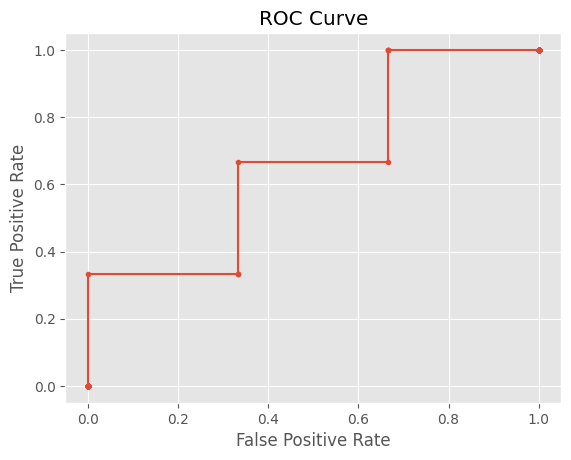

In [57]:
# create an ROC curve
import matplotlib.pyplot as plt
# set grid style
plt.style.use('ggplot')
import numpy as np
thresholds = np.linspace(-5, 5, 100)
tpr = []
fpr = []
for thresh in thresholds:
    y_pred_thresh = [1 if ( (1/2)*row['G3'] + (1/3)*row['G2'] - (1/4)*row['G1'] ) >= thresh else -1 for index, row in df.iterrows()]
    cm = sk_confusion_matrix(df['Y'], y_pred_thresh, labels=[1, -1])
    TP = cm[0, 0]
    TN = cm[1, 1]
    FP = cm[1, 0]
    FN = cm[0, 1]
    tpr.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
    fpr.append(FP / (FP + TN) if (FP + TN) > 0 else 0)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
from sklearn.metrics import roc_auc_score
y_scores = [( (1/2)*row['G3'] + (1/3)*row['G2'] - (1/4)*row['G1'] ) for index, row in df.iterrows()]
auc = roc_auc_score(df['Y'], y_scores)
auc